In [1]:
import ast
import itertools
import pathlib
import sys
import warnings

import joblib
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import toml
from joblib import dump
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import ElasticNetCV, LogisticRegression, MultiTaskElasticNetCV

# import mse
from sklearn.metrics import mean_squared_error, r2_score

# import RepeatedKFold
from sklearn.model_selection import (
    GridSearchCV,
    LeaveOneOut,
    RepeatedKFold,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.utils import parallel_backend

In [2]:
# Parameters
cell_type = "PBMC"
aggregation = True
nomic = True
flag = True
control = "DMSO_0.100_DMSO_0.025"
treatment = "LPS_100.000_DMSO_0.025"
shuffle = False

In [3]:
# set shuffle value
if shuffle:
    shuffle = "shuffled_baseline"
else:
    shuffle = "final"

In [4]:
MODEL_TYPE = "regression"
if flag == False:
    # read in toml file and get parameters
    toml_path = pathlib.Path("single_class_config.toml")
    with open(toml_path, "r") as f:
        config = toml.load(f)
    control = config["logistic_regression_params"]["control"]
    treatment = config["logistic_regression_params"]["treatments"]
    aggregation = ast.literal_eval(config["logistic_regression_params"]["aggregation"])
    nomic = ast.literal_eval(config["logistic_regression_params"]["nomic"])
    cell_type = config["logistic_regression_params"]["cell_type"]

In [5]:
# load training data from indexes and features dataframe
# data_split_path = pathlib.Path(f"../0.split_data/indexes/data_split_indexes.tsv")
# data_path = pathlib.Path(f"../../data/{cell_type}_preprocessed_sc_norm.parquet")
data_path = pathlib.Path(
    "../../data/PBMC_subset_sc_norm_DMSO_0.100_DMSO_0.025_LPS_100.000_DMSO_0.025.parquet"
)

# dataframe with only the labeled data we want (exclude certain phenotypic classes)
data_df = pq.read_table(data_path).to_pandas()

# import nomic data
nomic_df_path = pathlib.Path(
    f"../../2.Nomic_nELISA_Analysis/Data/clean/Plate2/nELISA_plate_430420_{cell_type}_cleanup4correlation.csv"
)
df_nomic = pd.read_csv(nomic_df_path)

# clean up nomic data
df_nomic = df_nomic.drop(columns=[col for col in df_nomic.columns if "[pgML]" in col])
# drop first 25 columns (Metadata that is not needed)
# df_nomic = df_nomic.drop(columns=df_nomic.columns[3:25])
# df_nomic = df_nomic.drop(columns=df_nomic.columns[0:2])

In [6]:
if (aggregation == True) and (nomic == True):
    data_split_path = pathlib.Path(
        f"../0.split_data/indexes/{cell_type}/{MODEL_TYPE}/{control}_{treatment}/aggregated_sc_and_nomic_data_split_indexes.tsv"
    )
    data_split_indexes = pd.read_csv(data_split_path, sep="\t", index_col=0)
    # subset each column that contains metadata
    metadata = data_df.filter(regex="Metadata")
    data_df = data_df.drop(metadata.columns, axis=1)
    data_df = pd.concat([data_df, metadata["Metadata_Well"]], axis=1)
    # groupby well and take mean of each well
    data_df = data_df.groupby("Metadata_Well").mean()
    # drop duplicate rows in the metadata_well column
    metadata = metadata.drop_duplicates(subset=["Metadata_Well"])
    # get the metadata for each well
    data_df = pd.merge(
        data_df, metadata, left_on="Metadata_Well", right_on="Metadata_Well"
    )
    data_df = pd.merge(
        data_df,
        df_nomic,
        left_on=["Metadata_Well", "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"],
        right_on=["Metadata_position_x", "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"],
    )
    data_df = data_df.drop(columns=["Metadata_position_x"])
elif (aggregation == True) and (nomic == False):
    data_split_path = pathlib.Path(
        f"../0.split_data/indexes/{cell_type}/{MODEL_TYPE}/{control}_{treatment}/aggregated_sc_data_split_indexes.tsv"
    )
    data_split_indexes = pd.read_csv(data_split_path, sep="\t", index_col=0)
    # subset each column that contains metadata
    metadata = data_df.filter(regex="Metadata")
    data_df = data_df.drop(metadata.columns, axis=1)
    data_df = pd.concat([data_df, metadata["Metadata_Well"]], axis=1)
    # groupby well and take mean of each well
    data_df = data_df.groupby("Metadata_Well").mean()
    # drop duplicate rows in the metadata_well column
    metadata = metadata.drop_duplicates(subset=["Metadata_Well"])
    # get the metadata for each well
    data_df = pd.merge(
        data_df,
        df_nomic,
        left_on=["Metadata_Well", "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"],
        right_on=["Metadata_position_x", "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"],
    )
elif (aggregation == False) and (nomic == True):
    data_split_path = pathlib.Path(
        f"../0.split_data/indexes/{cell_type}/{MODEL_TYPE}/{control}_{treatment}/sc_and_nomic_data_split_indexes.tsv"
    )
    data_split_indexes = pd.read_csv(data_split_path, sep="\t", index_col=0)
    data_df = pd.merge(
        data_df,
        df_nomic,
        left_on=["Metadata_Well", "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"],
        right_on=["Metadata_position_x", "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"],
    )
    data_df = data_df.drop(columns=["Metadata_position_x"])
elif aggregation == False and nomic == False:
    data_split_path = pathlib.Path(
        f"../0.split_data/indexes/{cell_type}/{MODEL_TYPE}/{control}_{treatment}/sc_split_indexes.tsv"
    )
    data_split_indexes = pd.read_csv(data_split_path, sep="\t", index_col=0)
else:
    print("Error")

In [7]:
# select tht indexes for the training and test set
train_indexes = data_split_indexes.loc[data_split_indexes["label"] == "train"]
test_indexes = data_split_indexes.loc[data_split_indexes["label"] == "test"]

In [8]:
# subset data_df by indexes in data_split_indexes
training_data = data_df.loc[train_indexes["labeled_data_index"]]
testing_data = data_df.loc[test_indexes["labeled_data_index"]]

In [9]:
# get oneb_Metadata_Treatment_Dose_Inhibitor_Dose  =='DMSO_0.100_DMSO_0.025' and 'LPS_100.000_DMSO_0.025 and Thapsigargin_10.000_DMSO_0.025'
training_data = training_data[
    training_data["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].isin(
        [control, treatment]
    )
]
testing_data = testing_data[
    testing_data["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].isin(
        [control, treatment]
    )
]

In [10]:
# at random downsample the DMSO treatment to match the number of wells in the LPS treatment
seed = 0
# get the number of wells in the LPS treatment
trt_wells = training_data[
    training_data["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] == treatment
].shape[0]
# get the number of wells in the DMSO treatment
dmso_wells = training_data[
    training_data["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] == control
].shape[0]
# downsample the DMSO treatment to match the number of wells in the LPS treatment
dmso_holdout = training_data[
    training_data["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] == control
].sample(n=trt_wells, random_state=seed)
# remove the downsampled DMSO wells from the data
training_data = training_data.drop(dmso_holdout.index)

In [11]:
# define metadata columns
# subset each column that contains metadata
metadata_train = training_data.filter(regex="Metadata")
# drop all metadata columns
train_data_x = training_data.drop(metadata_train.columns, axis=1)
train_treatments = training_data["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
# get all columns that contain "NSU" in the column name
train_data_y_cols = train_data_x.filter(regex="NSU").columns
train_data_y = training_data[train_data_y_cols]
train_data_x = train_data_x.drop(train_data_y_cols, axis=1)


# define metadata columns
# subset each column that contains metadata
metadata_test = testing_data.filter(regex="Metadata")
# drop all metadata columns
test_data_x = testing_data.drop(metadata_test.columns, axis=1)
test_treatments = testing_data["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
# get all columns that contain "NSU" in the column name
test_data_y_cols = test_data_x.filter(regex="NSU").columns
test_data_y = testing_data[test_data_y_cols]
test_data_x = test_data_x.drop(test_data_y_cols, axis=1)

In [12]:
train_data_y

,Activin A [NSU],AITRL (GITR Ligand) [NSU],Amphiregulin [NSU],Amyloid beta [NSU],APRIL [NSU],BAFF [NSU],BCMA (TNFRSF17) [NSU],BDNF [NSU],BMP2 [NSU],BMP3 [NSU],...,TWEAK [NSU],uPA [NSU],VCAM-1 [NSU],VEGF Receptor 2 (Flk-1) [NSU],VEGF-A (165) [NSU],VEGF-C [NSU],VEGF-D [NSU],VEGFR-1 [NSU],WISP-1 (CCN4) [NSU],XCL1 (Lymphotactin) [NSU]
1,0.061116,0.490832,0.339510,0.453362,0.414653,0.424223,0.702561,0.203464,0.502516,0.363301,...,0.424098,0.493033,0.171562,0.615867,0.288153,0.506528,0.264141,0.296782,0.541689,0.167078
2,0.064513,0.451181,0.246274,0.471026,0.269795,0.204498,0.247611,0.322087,0.350642,0.349237,...,0.454460,0.570146,0.032391,0.476656,0.315426,0.589522,0.381170,0.168645,0.455092,0.228752
10,0.837820,0.574834,0.869218,0.394956,0.118325,0.192057,0.584911,0.411283,0.340821,0.253736,...,0.328239,0.315633,0.364173,0.607592,0.176816,0.378920,0.310344,0.651217,0.679571,0.222324
11,0.686719,0.169058,0.759551,0.469769,0.464808,0.094883,0.345938,0.355706,0.262622,0.226736,...,0.360981,0.527316,0.405934,0.619578,0.329964,0.577830,0.000000,0.456104,0.255216,0.255703


In [13]:
print(train_data_x.shape, train_data_y.shape, test_data_x.shape, test_data_y.shape)

(4, 1245) (4, 187) (6, 1245) (6, 187)


In [14]:
# set model path from parameters
if (aggregation == True) and (nomic == True):
    model_path = pathlib.Path(
        f"models/regression/{cell_type}/aggregated_with_nomic/{control}__{treatment}"
    )
elif (aggregation == True) and (nomic == False):
    model_path = pathlib.Path(
        f"models/regression/{cell_type}/aggregated/{control}__{treatment}"
    )
elif (aggregation == False) and (nomic == True):
    model_path = pathlib.Path(
        f"models/regression/{cell_type}/sc_with_nomic/{control}__{treatment}"
    )
elif (aggregation == False) and (nomic == False):
    model_path = pathlib.Path(
        f"models/regression/{cell_type}/sc/{control}__{treatment}"
    )
else:
    print("Error")

In [15]:
data_dict = {
    "train_data": {
        "data_x": train_data_x,
        "data_y": train_data_y,
        "col_names": train_data_y_cols,
        "metadata": metadata_train,
    },
    "test_data": {
        "data_x": test_data_x,
        "data_y": test_data_y,
        "col_names": test_data_y_cols,
        "metadata": metadata_test,
    },
}

In [17]:
# cross validation method
loo = LeaveOneOut()

# lsit of metrics to use
metrics = ["explained_variance", "neg_mean_absolute_error", "neg_mean_squared_error"]
output_metric_scores = {}

In [18]:
# blank df for concatenated results
results_df = pd.DataFrame(
    columns=[
        "explained_variance",
        "neg_mean_absolute_error",
        "neg_mean_squared_error",
        "well",
        "treatment",
        "r2",
        "cytokine",
        "data_split",
        "shuffle",
        "predicted_value",
        "actual_value",
        "log10_neg_mean_absolute_error",
        "log10_neg_mean_squared_error",
        "log10_explained_variance",
    ]
)

In [19]:
# for cytokine in train_data_y_cols:
cytokine = "Activin A [NSU]"
for data_split in data_dict:
    print(data_split)
    for i in data_dict[data_split]:
        print(i)
        data_x = data_dict[data_split]["data_x"]
        data_y = data_dict[data_split]["data_y"]
        col_names = data_dict[data_split]["col_names"]
        metadata = data_dict[data_split]["metadata"]
    if shuffle == "shuffled_baseline":
        model = joblib.load(
            f"../1.train_models/{model_path}/{cytokine}_shuffled_baseline__all_nomic.joblib"
        )
    elif shuffle == "final":
        model = joblib.load(
            f"../1.train_models/{model_path}/{cytokine}_final__all_nomic.joblib"
        )
    else:
        print("Error")

    # get the cytokine column of choice
    y_selected = data_y[cytokine]

    if shuffle == True:
        for column in data_x:
            np.random.shuffle(data_x[column].values)

    # get predictions
    predictions = model.predict(data_x)
    for metric in metrics:
        scores = cross_val_score(
            model, data_x, y_selected, scoring=metric, cv=loo, n_jobs=-1
        )
        output_metric_scores[metric] = scores
    r2 = r2_score(y_selected, predictions)
    output_metric_scores["treatment"] = metadata[
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"
    ]
    output_metric_scores["well"] = metadata["Metadata_Well"]
    print(output_metric_scores)
    df = pd.DataFrame.from_dict(output_metric_scores)
    df["r2"] = r2
    df["cytokine"] = cytokine
    df["data_split"] = data_split
    df["shuffle"] = shuffle
    df["predicted_value"] = predictions
    df["actual_value"] = y_selected
    df["log10_neg_mean_absolute_error"] = -np.log10(-df["neg_mean_absolute_error"])
    df["log10_neg_mean_squared_error"] = -np.log10(-df["neg_mean_squared_error"])
    df["log10_explained_variance"] = -np.log10(df["explained_variance"])

    # replace "[NSU]" with """
    df["cytokine"] = df["cytokine"].replace("[ \[\]NSU]", "", regex=True)
    df["cytokine"] = df["cytokine"].replace(" ", "_", regex=True)

    # concat the dataframes
    results_df = pd.concat([results_df, df], axis=0)

train_data
data_x
data_y
col_names
metadata
{'explained_variance': array([1., 1., 1., 1.]), 'neg_mean_absolute_error': array([-0.15881661, -0.19038779, -0.19728791, -0.19061383]), 'neg_mean_squared_error': array([-0.02522272, -0.03624751, -0.03892252, -0.03633363]), 'treatment': 1      DMSO_0.100_DMSO_0.025
2      DMSO_0.100_DMSO_0.025
10    LPS_100.000_DMSO_0.025
11    LPS_100.000_DMSO_0.025
Name: oneb_Metadata_Treatment_Dose_Inhibitor_Dose, dtype: object, 'well': 1     B07
2     C06
10    J08
11    J09
Name: Metadata_Well, dtype: object}
test_data
data_x
data_y
col_names
metadata
{'explained_variance': array([1., 1., 1., 1., 1., 1.]), 'neg_mean_absolute_error': array([-0.31490242, -0.04458667, -0.09835407, -0.36854621, -0.31507448,
       -0.31495832]), 'neg_mean_squared_error': array([-0.09916354, -0.00198797, -0.00967352, -0.13582631, -0.09927193,
       -0.09919874]), 'treatment': 0     DMSO_0.100_DMSO_0.025
3     DMSO_0.100_DMSO_0.025
4     DMSO_0.100_DMSO_0.025
5     DMSO_0.100_

In [20]:
results_df

,explained_variance,neg_mean_absolute_error,neg_mean_squared_error,well,treatment,r2,cytokine,data_split,shuffle,predicted_value,actual_value,log10_neg_mean_absolute_error,log10_neg_mean_squared_error,log10_explained_variance
1,1.0,-0.158817,-0.025223,B07,DMSO_0.100_DMSO_0.025,0.860303,ActivinA,train_data,final,0.290576,0.061116,0.799104,1.598208,-0.0
2,1.0,-0.190388,-0.036248,C06,DMSO_0.100_DMSO_0.025,0.860303,ActivinA,train_data,final,0.195996,0.064513,0.720361,1.440722,-0.0
10,1.0,-0.197288,-0.038923,J08,LPS_100.000_DMSO_0.025,0.860303,ActivinA,train_data,final,0.837203,0.837820,0.704900,1.409799,-0.0
11,1.0,-0.190614,-0.036334,J09,LPS_100.000_DMSO_0.025,0.860303,ActivinA,train_data,final,0.686762,0.686719,0.719846,1.439691,-0.0
0,1.0,-0.314902,-0.099164,B06,DMSO_0.100_DMSO_0.025,0.757677,ActivinA,test_data,final,0.098134,0.097710,0.501824,1.003648,-0.0
3,1.0,-0.044587,-0.001988,C07,DMSO_0.100_DMSO_0.025,0.757677,ActivinA,test_data,final,0.225119,0.053236,1.350795,2.701590,-0.0
4,1.0,-0.098354,-0.009674,I06,DMSO_0.100_DMSO_0.025,0.757677,ActivinA,test_data,final,0.062057,0.061860,1.007208,2.014415,-0.0
5,1.0,-0.368546,-0.135826,I07,DMSO_0.100_DMSO_0.025,0.757677,ActivinA,test_data,final,0.465406,0.093970,0.433508,0.867016,-0.0
6,1.0,-0.315074,-0.099272,J02,LPS_100.000_DMSO_0.025,0.757677,ActivinA,test_data,final,0.706392,0.706485,0.501587,1.003174,-0.0
7,1.0,-0.314958,-0.099199,J03,LPS_100.000_DMSO_0.025,0.757677,ActivinA,test_data,final,0.799974,0.957122,0.501747,1.003494,-0.0


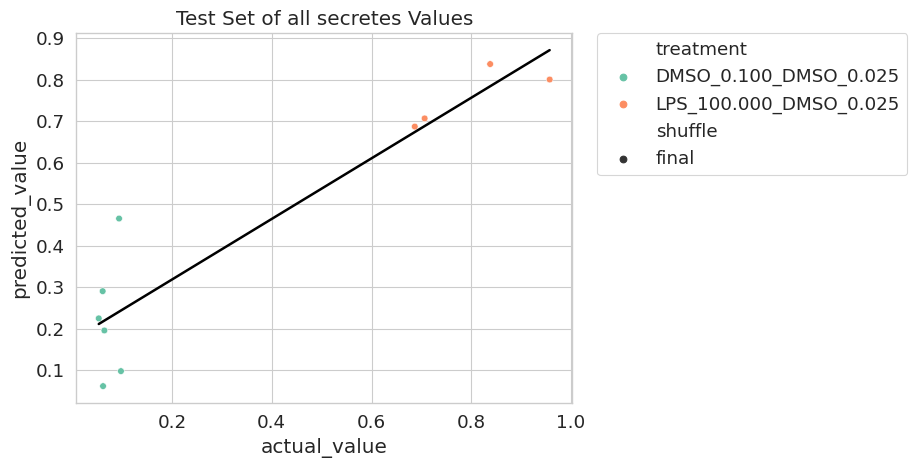

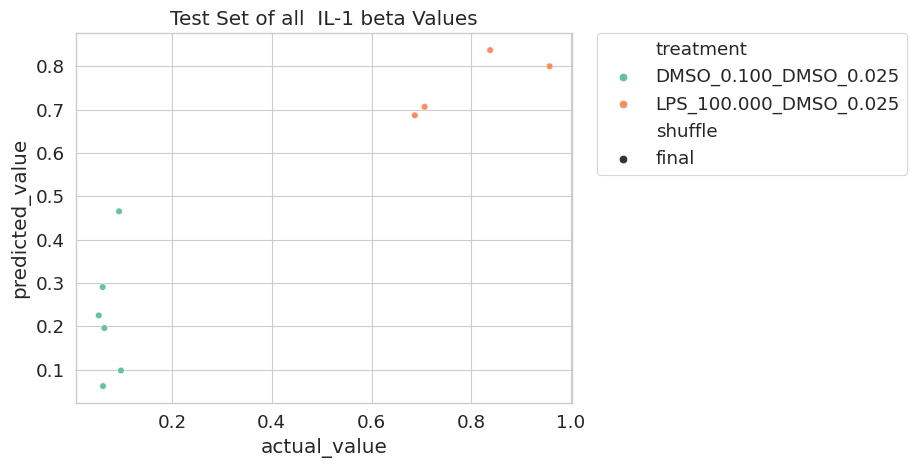

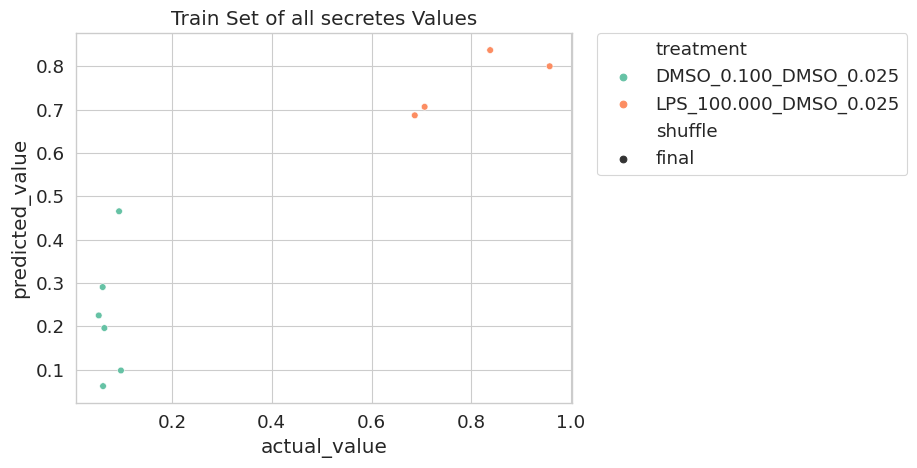

In [21]:
import matplotlib.pyplot as plt

# plot the predictions
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)

# plot the df compiled_predictions scatter plot
# sns.scatterplot(data=predicted_df_train, x='actual', y='predicted', hue='treatment', style='shuffled', palette='Set2')
# plt.show()
# plt.close()

sns.scatterplot(
    data=results_df,
    x="actual_value",
    y="predicted_value",
    hue="treatment",
    style="shuffle",
    palette="Set2",
)
# move legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
# add a fitted line of best fit for each color and shape combination
sns.regplot(
    data=results_df,
    x="actual_value",
    y="predicted_value",
    scatter=False,
    ci=None,
    color="black",
)
plt.title("Test Set of all secretes Values")
plt.show()
plt.close()


sns.scatterplot(
    data=results_df,
    x="actual_value",
    y="predicted_value",
    hue="treatment",
    style="shuffle",
    palette="Set2",
)
# move legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.title("Test Set of all  IL-1 beta Values")
plt.show()
plt.close()


# plot the df compiled_predictions scatter plot
sns.scatterplot(
    data=results_df,
    x="actual_value",
    y="predicted_value",
    hue="treatment",
    style="shuffle",
    palette="Set2",
)
# move legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.title("Train Set of all secretes Values")
plt.show()
plt.close()

In [22]:
# set model path from parameters
if (aggregation == True) and (nomic == True):
    results_path = pathlib.Path(
        f"results/regression/{cell_type}/aggregated_with_nomic/{control}__{treatment}"
    )
elif (aggregation == True) and (nomic == False):
    results_path = pathlib.Path(
        f"results/regression/{cell_type}/aggregated/{control}__{treatment}"
    )
elif (aggregation == False) and (nomic == True):
    results_path = pathlib.Path(
        f"results/regression/{cell_type}/sc_with_nomic/{control}__{treatment}"
    )
elif (aggregation == False) and (nomic == False):
    results_path = pathlib.Path(
        f"results/regression/{cell_type}/sc/{control}__{treatment}"
    )
else:
    print("Error")
pathlib.Path(results_path).mkdir(parents=True, exist_ok=True)

In [24]:
# check if the model training metrics file exists
metrics_file = pathlib.Path(f"{results_path}/model_stats.csv")
if metrics_file.exists():
    metrics_df = pd.read_csv(metrics_file)
    if len(metrics_df["shuffle"].unique()) > 1:
        pass
    else:
        metrics_df = pd.concat([metrics_df, results_df], axis=0)
        metrics_df.to_csv(metrics_file, index=False)
else:
    results_df.to_csv(metrics_file, index=False)